# 0. 기본 정보
* 코드 작성자: 여서연
* 코드 작성일: 2024-11-16
* 코드 작성 목적: NLP 및 LDA 토픽 모델링

## 참조 코드 - Topic Modeling using LDA

* https://joyhong.tistory.com/138
* https://github.com/FifthSaint/NewsTextMining201903
* https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
* https://github.com/fastai/course-nlp/blob/master/2-svd-nmf-topic-modeling.ipynb

# 1. 기초 설정

## 사용 라이브러리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from konlpy.tag import *

In [3]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

In [4]:
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

In [5]:
import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 처리

## A. 크롤링 데이터 불러오기

In [6]:
week_1st = pd.read_csv("../data/[속보]_['10']월_1기간_news_data.csv")
week_2nd = pd.read_csv("../data/[속보]_['10']월_2기간_news_data.csv")
week_3rd = pd.read_csv("../data/[속보]_['10']월_3기간_news_data.csv")
week_4th = pd.read_csv("../data/[속보]_['10']월_4기간_news_data.csv")

In [7]:
print(week_1st.shape)
print(week_2nd.shape)
print(week_3rd.shape)
print(week_4th.shape)

(793, 4)
(800, 4)
(643, 4)
(800, 4)


In [8]:
docs_1 = []
for idx in range(len(week_1st)):
    docs_1.append(week_1st['Title'][idx])

docs_2 = []
for idx in range(len(week_2nd)):
    docs_2.append(week_2nd['Title'][idx])

docs_3 = []
for idx in range(len(week_3rd)):
    docs_3.append(week_3rd['Title'][idx])

docs_4 = []
for idx in range(len(week_4th)):
    docs_4.append(week_4th['Title'][idx])

In [9]:
print(docs_1)
print(docs_2)
print(docs_3)
print(docs_4)

['[속보] 이스라엘군, 레바논 남부 접경 마을 20여곳 소개령', '[속보] 나토 “한국 등 인태 4개국, 나토 국방장관회의 첫 참석 예정”', '[속보] 이시바 시게루, 일본 총리 공식 선출…오늘 새 내각 출범', '[속보] 헤즈볼라 "텔아비브 인근 모사드 본부 미사일 공격"', '[속보] 이스라엘 "레바논 수도 베이루트 정밀 폭격"', '[속보]9월 수출 7.5% 증가…반도체 136억달러 ‘역대 최대’', '[속보]광양 23층 아파트서 투신 19세女…극적 구조 성공', '[속보] 이스라엘군 "레바논 남부 \'지상 습격\' 시작…헤즈볼라 테러 목표...', '[속보]“北으로 돌아갈래”…마을버스 훔쳐 통일대교 건너려던 탈북민...', '[속보] 이시바, 일본 102대 총리로 선출…오늘 새 내각 출범', '[속보] 이스라엘, 레바논 접경지 봉쇄 거센 포격…지상전 조짐', '[속보] 北유엔대사 "합법적 자위권 놓고 과거로 돌아가지 않을 것"', '[속보] 윤대통령 "북, 핵무기 사용 기도하는 그날 정권 종말의 날"', '[속보] 이시바, 일본 102대 총리로 선출…오늘 새 내각 출범', '[속보] 이스라엘군, 레바논 향해 ‘국지적 침공’ 시작···지상전 초읽...', '[속보] 이스라엘 "방공망 완벽 준비…이란, 공격시 대가치러야"', '[속보]비트코인 3% 대 급락, 6만4000 달러선 깨져…‘이시바 쇼크’ 탓?', '[속보] 이스라엘 "레바논 지상작전 되도록 신속히 완료"', '[속보] 日이시바 총리 "납북 피해자 문제 해결에 강한 결의"', '[속보] "헤즈볼라, 이스라엘 지상군 레바논 진입 부인"<AFP>', '[속보] 美백악관 "이란, 이스라엘 직접 군사공격시 심각한 결과 있을것...', '[속보] 이스라엘 "지난 1년간 레바논서 수십회 소규모 지상작전"', '[속보] 헤즈볼라 "텔아비브 인근 모사드 본부 미사일 공격"', '[속보] 롯데 레이예스, 시즌 최종전서 202안타…최다안타 신기록', '[속보] 미국 동남부 항만 폐쇄·파업 시작…노사협상 결렬'

## B. 구두점 처리

In [10]:
# 제거할 문자와 그 대체값을 딕셔너리로 정의
remove_dict = {
    '.': ' ',   # 마침표 제거
    ',': ' ',   # 쉼표 제거
    "'": ' ',   # 작은따옴표 제거
    '"': ' ',   # 큰따옴표 제거
    '·': ' ',  # 중간 점을 공백으로 대체
    '=': ' ',   # 등호 제거
    '\\n': ' ',  # 개행 문자 제거
    '[': ' ',
    ']': ' ',
    '…': ' ',
    '\\': ' '
}

In [11]:
# 여러 문자 제거를 위한 함수 생성
def CleanText(text, remove_dict):
    for key, value in remove_dict.items():
        text = text.replace(key, value)
    return text

In [12]:
doc_set_1 = []
for doc in docs_1:
    doc_set_1.append(CleanText(doc, remove_dict))

doc_set_2 = []
for doc in docs_2:
    doc_set_2.append(CleanText(doc, remove_dict))

doc_set_3 = []
for doc in docs_3:
    doc_set_3.append(CleanText(doc, remove_dict))

doc_set_4 = []
for doc in docs_4:
    doc_set_4.append(CleanText(doc, remove_dict))

In [13]:
print(doc_set_1)
print(doc_set_2)
print(doc_set_3)
print(doc_set_4)

[' 속보  이스라엘군  레바논 남부 접경 마을 20여곳 소개령', ' 속보  나토 “한국 등 인태 4개국  나토 국방장관회의 첫 참석 예정”', ' 속보  이시바 시게루  일본 총리 공식 선출 오늘 새 내각 출범', ' 속보  헤즈볼라  텔아비브 인근 모사드 본부 미사일 공격 ', ' 속보  이스라엘  레바논 수도 베이루트 정밀 폭격 ', ' 속보 9월 수출 7 5% 증가 반도체 136억달러 ‘역대 최대’', ' 속보 광양 23층 아파트서 투신 19세女 극적 구조 성공', ' 속보  이스라엘군  레바논 남부  지상 습격  시작 헤즈볼라 테러 목표   ', ' 속보 “北으로 돌아갈래” 마을버스 훔쳐 통일대교 건너려던 탈북민   ', ' 속보  이시바  일본 102대 총리로 선출 오늘 새 내각 출범', ' 속보  이스라엘  레바논 접경지 봉쇄 거센 포격 지상전 조짐', ' 속보  北유엔대사  합법적 자위권 놓고 과거로 돌아가지 않을 것 ', ' 속보  윤대통령  북  핵무기 사용 기도하는 그날 정권 종말의 날 ', ' 속보  이시바  일본 102대 총리로 선출 오늘 새 내각 출범', ' 속보  이스라엘군  레바논 향해 ‘국지적 침공’ 시작   지상전 초읽   ', ' 속보  이스라엘  방공망 완벽 준비 이란  공격시 대가치러야 ', ' 속보 비트코인 3% 대 급락  6만4000 달러선 깨져 ‘이시바 쇼크’ 탓?', ' 속보  이스라엘  레바논 지상작전 되도록 신속히 완료 ', ' 속보  日이시바 총리  납북 피해자 문제 해결에 강한 결의 ', ' 속보   헤즈볼라  이스라엘 지상군 레바논 진입 부인 <AFP>', ' 속보  美백악관  이란  이스라엘 직접 군사공격시 심각한 결과 있을것   ', ' 속보  이스라엘  지난 1년간 레바논서 수십회 소규모 지상작전 ', ' 속보  헤즈볼라  텔아비브 인근 모사드 본부 미사일 공격 ', ' 속보  롯데 레이예스  시즌 최종전서 202안타 최다안타 신기록', ' 속보  미국 동남부 항만 폐쇄 파업 시작 노사협상 결렬', 

## C. 불용어 및 자연어 처리

In [14]:
terms_1 = []
terms_2 = []
terms_3 = []
terms_4 = []

In [15]:
stop_word = '속보 그 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 소리 놓'
stopword_list = stop_word.split(' ')
print(stopword_list)

['속보', '그', '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [16]:
# 형태소 분석기 별 성능 비교
text = doc_set_2[22]
print(text,'\n')

# Hannanum 분석기 사용
hannanum = Hannanum()
print("Hannanum 분석:", hannanum.morphs(text))  # 형태소 추출
print("Hannanum 명사 추출:", hannanum.nouns(text))  # 명사 추출
print("Hannanum 품사 태깅:", hannanum.pos(text))  # 품사 태깅
print()

# Kkma 분석기 사용
kkma = Kkma()
print("Kkma 분석:", kkma.morphs(text))  # 형태소 추출
print("Kkma 명사 추출:", kkma.nouns(text))  # 명사 추출
print("Kkma 품사 태깅:", kkma.pos(text))  # 품사 태깅
print()

# Okt 분석기 사용
okt = Okt()
print("Okt 분석:", okt.morphs(text))  # 형태소 추출
print("Okt 명사 추출:", okt.nouns(text))  # 명사 추출
print("Okt 품사 태깅:", okt.pos(text))  # 품사 태깅

 속보  북  9일부터 南연결 도로 철길 단절 요새화 공사 진행  

Hannanum 분석: ['속보', '북', '9일', '부터', '南연결', '도', '로', '철길', '단절', '요새화', '공사', '진행']
Hannanum 명사 추출: ['속보', '9일', '南연결', '도', '철길', '단절', '요새화', '공사', '진행']
Hannanum 품사 태깅: [('속보', 'N'), ('북', 'M'), ('9일', 'N'), ('부터', 'J'), ('南연결', 'N'), ('도', 'N'), ('로', 'J'), ('철길', 'N'), ('단절', 'N'), ('요새화', 'N'), ('공사', 'N'), ('진행', 'N')]

Kkma 분석: ['속보', '북', '9', '일', '부터', '南', '연결', '도로', '철길', '단절', '요새', '화', '공사', '진행']
Kkma 명사 추출: ['속보', '북', '9', '9일', '일', '연결', '도로', '철길', '단절', '요새', '공사', '진행']
Kkma 품사 태깅: [('속보', 'NNG'), ('북', 'NNG'), ('9', 'NR'), ('일', 'NNM'), ('부터', 'JX'), ('南', 'OH'), ('연결', 'NNG'), ('도로', 'NNG'), ('철길', 'NNG'), ('단절', 'NNG'), ('요새', 'NNG'), ('화', 'XSN'), ('공사', 'NNG'), ('진행', 'NNG')]

Okt 분석: ['속보', '북', '9일', '부터', '南', '연결', '도로', '철길', '단절', '요새화', '공사', '진행']
Okt 명사 추출: ['속보', '북', '연결', '도로', '철길', '단절', '요새화', '공사', '진행']
Okt 품사 태깅: [('속보', 'Noun'), ('북', 'Noun'), ('9일', 'Number'), ('부터', 'Foreign'), ('南', 'Foreign'), 

In [17]:
for w in doc_set_1:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms_1.append(stop_tokens)

for w in doc_set_2:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms_2.append(stop_tokens)

for w in doc_set_3:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms_3.append(stop_tokens)

for w in doc_set_4:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms_4.append(stop_tokens)

In [18]:
print(terms_1)
print(terms_2)
print(terms_3)
print(terms_4)

[['이스라엘군', '레바논', '남부', '접경', '마을', '곳', '소개', '령'], ['나토', '한국', '인태', '개국', '나토', '국방', '장관', '회의', '첫', '참석', '예정'], ['시바', '시게루', '일본', '총리', '공식', '선출', '오늘', '새', '내각', '출범'], ['헤즈볼라', '텔아비브', '인근', '모사드', '본부', '미사일', '공격'], ['이스라엘', '레바논', '수도', '베이루트', '정밀', '폭격'], ['수출', '증가', '반도체', '역대', '최대'], ['광양', '층', '아파트', '투신', '세', '극적', '구조', '성공'], ['이스라엘군', '레바논', '남부', '지상', '습격', '시작', '헤즈볼라', '테러', '목표'], ['마을', '버스', '통일대교', '탈북민'], ['시바', '일본', '총리', '선출', '오늘', '새', '내각', '출범'], ['이스라엘', '레바논', '접경', '봉쇄', '거', '포격', '지상전', '조짐'], ['유엔', '대사', '합법', '자위권', '과거'], ['윤', '대통령', '북', '핵무기', '사용', '기도', '그날', '정권', '종말', '날'], ['시바', '일본', '총리', '선출', '오늘', '새', '내각', '출범'], ['이스라엘군', '레바논', '향', '국', '지적', '침공', '시작', '지상전', '초'], ['이스라엘', '방공', '망', '완벽', '준비', '이란', '공격', '시', '대가'], ['비트코인', '급락', '달러', '선', '시바', '쇼크', '탓'], ['이스라엘', '레바논', '지상', '작전', '완료'], ['시바', '총리', '납북', '피해자', '해결', '결의'], ['헤즈볼라', '이스라엘', '지상군', '레바논', '진입', '부인'], ['백악관', '이란', '이스라엘', '직접', '군사

## D. 사전과 문서-단어행렬 생성

In [19]:
#training vocabulary
dictionary_1 = corpora.Dictionary(terms_1)
dictionary_2 = corpora.Dictionary(terms_2)
dictionary_3 = corpora.Dictionary(terms_3)
dictionary_4 = corpora.Dictionary(terms_4)

In [20]:
## 문서-단어 행렬(document-term matrix) 생성
corpus_1 = [dictionary_1.doc2bow(term) for term in terms_1]
corpus_2 = [dictionary_2.doc2bow(term) for term in terms_2]
corpus_3 = [dictionary_3.doc2bow(term) for term in terms_3]
corpus_4 = [dictionary_4.doc2bow(term) for term in terms_4]

In [21]:
print(dictionary_1, '\n')
print(dictionary_2, '\n')
print(dictionary_3, '\n')
print(dictionary_4)

Dictionary<1836 unique tokens: ['곳', '남부', '레바논', '령', '마을']...> 

Dictionary<1885 unique tokens: ['대통령', '라오스', '시바', '정상회담', '첫']...> 

Dictionary<1521 unique tokens: ['가능성', '사망', '신와르', '이스라엘군', '지도자']...> 

Dictionary<1866 unique tokens: ['단계', '대응', '미군기지', '발령', '부산']...>


In [22]:
print(corpus_1, '\n')
print(corpus_2, '\n')
print(corpus_3, '\n')
print(corpus_4)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(2, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(40, 1), (41, 1), (42, 1), (43, 1), (44, 1)], [(45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)], [(1, 1), (2, 1), (6, 1), (34, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(4, 1), (58, 1), (59, 1), (60, 1)], [(19, 1), (20, 1), (21, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(2, 1), (7, 1), (37, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1)], [(66, 1), (67, 1), (68, 1), (69, 1), (70, 1)], [(71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)], [(19, 1), (20, 1), (21, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(2, 1), (6, 1), (55, 1), (64, 1),

## E. TF-IDF 계산

In [23]:
#tfidf document-term matrix
tfidf_1 = models.TfidfModel(corpus_1)
corpus_tfidf_1 = tfidf_1[corpus_1]
corpus_tfidf_1[0][:5]

[(0, 0.4497113250517876),
 (1, 0.3096314607369322),
 (2, 0.18754206067480705),
 (3, 0.4030180369468358),
 (4, 0.3096314607369322)]

In [24]:
#tfidf document-term matrix
tfidf_2 = models.TfidfModel(corpus_2)
corpus_tfidf_2 = tfidf_2[corpus_2]
corpus_tfidf_2[0][:5]

[(0, 0.2719291481728554),
 (1, 0.4337267068907654),
 (2, 0.378115103195373),
 (3, 0.4729167834781762),
 (4, 0.36150498164398825)]

In [25]:
#tfidf document-term matrix
tfidf_3 = models.TfidfModel(corpus_3)
corpus_tfidf_3 = tfidf_3[corpus_3]
corpus_tfidf_3[0][:5]

[(0, 0.4452084779747268),
 (1, 0.2921068989258251),
 (2, 0.3117141000663088),
 (3, 0.4028381893556479),
 (4, 0.47883966806431966)]

In [26]:
#tfidf document-term matrix
tfidf_4 = models.TfidfModel(corpus_4)
corpus_tfidf_4 = tfidf_4[corpus_4]
corpus_tfidf_4[0][:5]

[(0, 0.3508376666903285),
 (1, 0.2841525646547981),
 (2, 0.47969389896728176),
 (3, 0.4472311952202524),
 (4, 0.3687031817605941)]

## F. LDA 분석

In [27]:
model_1 = gensim.models.LdaModel(
    corpus_1,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary_1,
    random_state=42
)

In [28]:
model_2 = gensim.models.LdaModel(
    corpus_2,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary_2,
    random_state=42
)

In [29]:
model_3 = gensim.models.LdaModel(
    corpus_3,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary_3,
    random_state=42
)

In [30]:
model_4 = gensim.models.LdaModel(
    corpus_4,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary_4,
    random_state=42
)

In [31]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
print(model_1.show_topics(4, 10), '\n')
print(model_2.show_topics(4, 10), '\n')
print(model_3.show_topics(4, 10), '\n')
print(model_4.show_topics(4, 10))

[(2, '0.013*"윤" + 0.009*"민주" + 0.009*"대통령" + 0.008*"대응" + 0.008*"시바" + 0.007*"이스라엘" + 0.006*"일화" + 0.006*"음주운전" + 0.006*"협력" + 0.006*"입건"'), (7, '0.012*"이스라엘" + 0.008*"고려아연" + 0.008*"사주" + 0.007*"헤즈볼라" + 0.007*"윤" + 0.007*"한일" + 0.007*"과" + 0.007*"자" + 0.006*"뉴욕증시" + 0.006*"거짓말"'), (6, '0.009*"레바논" + 0.008*"이스라엘" + 0.007*"의회" + 0.007*"헤즈볼라" + 0.007*"미국" + 0.007*"판매" + 0.007*"사태" + 0.007*"감소" + 0.006*"검찰" + 0.006*"원주"'), (4, '0.025*"레바논" + 0.015*"도착" + 0.014*"국민" + 0.014*"체류" + 0.014*"수송기" + 0.013*"군" + 0.010*"서울" + 0.009*"휴학" + 0.009*"공항" + 0.009*"이스라엘"')] 

[(2, '0.010*"한강" + 0.010*"북한" + 0.010*"합참" + 0.007*"선" + 0.007*"뉴스" + 0.007*"마감" + 0.007*"검찰" + 0.007*"호" + 0.006*"홍명보" + 0.006*"한국"'), (6, '0.013*"당선" + 0.013*"교육감" + 0.011*"정근" + 0.009*"서울시" + 0.009*"율" + 0.008*"영풍" + 0.008*"금정" + 0.008*"유력" + 0.007*"주장" + 0.007*"확보"'), (3, '0.009*"한강" + 0.008*"대통령" + 0.006*"최고" + 0.006*"국민" + 0.006*"진보당" + 0.006*"중단" + 0.006*"행위" + 0.006*"즉각" + 0.006*"긴장" + 0.006*"한반도"'), (4, '0.014*"노벨" + 0.013

In [32]:
NUM_TOPICS = 9
TOP_N = 20

In [33]:
word_dict_1 = {}
word_dict_2 = {}
word_dict_3 = {}
word_dict_4 = {}

In [34]:
for i in range(NUM_TOPICS):
  words = model_1.show_topic(i, topn=TOP_N)
  word_dict_1['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df_1 = pd.DataFrame(word_dict_1)

In [35]:
for i in range(NUM_TOPICS):
  words = model_2.show_topic(i, topn=TOP_N)
  word_dict_2['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df_2 = pd.DataFrame(word_dict_2)

In [36]:
for i in range(NUM_TOPICS):
  words = model_3.show_topic(i, topn=TOP_N)
  word_dict_3['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df_3 = pd.DataFrame(word_dict_3)

In [37]:
for i in range(NUM_TOPICS):
  words = model_4.show_topic(i, topn=TOP_N)
  word_dict_4['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df_4 = pd.DataFrame(word_dict_4)

In [38]:
word_df_1

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,대통령,윤,윤,대통령,레바논,전자,레바논,이스라엘,필리핀
1,윤,대통령,민주,윤,도착,영업,이스라엘,고려아연,대통령
2,이스라엘,특검법,대통령,대통령실,국민,삼성,의회,사주,뉴욕증시
3,싱가포르,부결,대응,김건희,체류,익,헤즈볼라,헤즈볼라,쓰레기
4,필리핀,이란,시바,위,수송기,예고,미국,윤,부양
5,이란,전자,이스라엘,북한,군,활,판매,한일,일제
6,순방,레바논,일화,여사,서울,소비,사태,과,새
7,내일,이스라엘,음주운전,국회,휴학,성장,감소,자,총리
8,사업,공격,협력,국악,공항,부진,검찰,뉴욕증시,나스닥
9,보복,김건희,입건,풍선,이스라엘,투자,원주,거짓말,전략


In [39]:
word_df_2

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,한강,한강,한강,한강,노벨,대통령,당선,무인기,한국
1,명태,노벨문학상,북한,대통령,한국,은,교육감,한국,무인기
2,균,수상,합참,최고,한강,대통령실,정근,군수,평양
3,노벨문학상,무인기,선,국민,윤,개월,서울시,곡성,침투
4,수상,평양,뉴스,진보당,정부,기준금리,율,평양,북
5,국감,합참,마감,중단,율,택시,영풍,대통령,확인
6,노벨상,작가,검찰,행위,수상,종말,금정,윤,한강
7,추가,한국,호,즉각,투표,최근,유력,조상래,합참
8,첫,정부,홍명보,긴장,무인기,한국,주장,민주당,쾌거
9,운영,대통령,한국,한반도,국민,인하,확보,아세안,줄


In [40]:
word_df_3

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,한국,한동훈,러북,김건희,러시아,파병,경제,윤,경제
1,시리즈,면담,북한,대통령실,경찰,국정원,대통령,대통령,성장
2,위해,대통령,이번,여사,대통령,러시아,한동훈,대통령실,대통령
3,대통령,윤,정부,한국,파병,김,대통령실,파병,북한
4,감찰관,신와르,일정,검찰,북한,오자,발표,러시아,한동훈
5,유럽,사망,당선,의혹,한동훈,여사,대표,한동훈,인하
6,발,인천,안보,북한,대표,북한,회의,도박,치
7,지난해,김여사,파병,협력,동행,북,국정감사,상치,발표
8,진출,일정,합의,오자,명령,이동,윤,판매,윤
9,윤,활동,국민,글,출석,뜻,여사,전월,조치


In [41]:
word_df_4

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,한국,북한,대통령실,경제,위,이란,이란,영업,북한
1,북한,대통령실,파병,대통령,대통령실,북한,국정원,북한,이란
2,파병,영업,대통령,성장,북한,이스라엘,이스라엘,파병,삼성
3,세,주간,윤,률,장관,차,북,익,주간
4,우승,파병,지원,한동훈,윤,비트코인,대북,개혁,고려아연
5,김수미,이스라엘,북한,위해,률,대통령실,코스피,투입,이스라엘
6,영업,이란,법,세,내년,대응,러시아,전자,백악관
7,계약,검토,러시아,향년,가능성,국정원,성장,실적,발사
8,별세,키,뉴욕증시,올해,성장,휴학,범,북,이동
9,신세계,실적,검토,김수미,수출,의대,취소,전선,파병


In [42]:
model_1.print_topics(num_words=5)

[(0, '0.021*"대통령" + 0.010*"윤" + 0.009*"이스라엘" + 0.009*"싱가포르" + 0.008*"필리핀"'),
 (1, '0.014*"윤" + 0.014*"대통령" + 0.009*"특검법" + 0.008*"부결" + 0.008*"이란"'),
 (2, '0.013*"윤" + 0.009*"민주" + 0.009*"대통령" + 0.008*"대응" + 0.008*"시바"'),
 (3, '0.016*"대통령" + 0.016*"윤" + 0.009*"대통령실" + 0.009*"김건희" + 0.009*"위"'),
 (4, '0.025*"레바논" + 0.015*"도착" + 0.014*"국민" + 0.014*"체류" + 0.014*"수송기"'),
 (5, '0.016*"전자" + 0.013*"영업" + 0.013*"삼성" + 0.012*"익" + 0.007*"예고"'),
 (6, '0.009*"레바논" + 0.008*"이스라엘" + 0.007*"의회" + 0.007*"헤즈볼라" + 0.007*"미국"'),
 (7, '0.012*"이스라엘" + 0.008*"고려아연" + 0.008*"사주" + 0.007*"헤즈볼라" + 0.007*"윤"'),
 (8, '0.014*"필리핀" + 0.010*"대통령" + 0.008*"뉴욕증시" + 0.008*"쓰레기" + 0.008*"부양"')]

In [43]:
model_2.print_topics(num_words=5)

[(0, '0.016*"한강" + 0.013*"명태" + 0.013*"균" + 0.010*"노벨문학상" + 0.008*"수상"'),
 (1, '0.028*"한강" + 0.021*"노벨문학상" + 0.019*"수상" + 0.012*"무인기" + 0.010*"평양"'),
 (2, '0.010*"한강" + 0.010*"북한" + 0.010*"합참" + 0.007*"선" + 0.007*"뉴스"'),
 (3, '0.009*"한강" + 0.008*"대통령" + 0.006*"최고" + 0.006*"국민" + 0.006*"진보당"'),
 (4, '0.014*"노벨" + 0.013*"한국" + 0.010*"한강" + 0.008*"윤" + 0.007*"정부"'),
 (5, '0.015*"대통령" + 0.012*"은" + 0.007*"대통령실" + 0.007*"개월" + 0.007*"기준금리"'),
 (6, '0.013*"당선" + 0.013*"교육감" + 0.011*"정근" + 0.009*"서울시" + 0.009*"율"'),
 (7, '0.015*"무인기" + 0.015*"한국" + 0.011*"군수" + 0.009*"곡성" + 0.009*"평양"'),
 (8, '0.015*"한국" + 0.014*"무인기" + 0.014*"평양" + 0.012*"침투" + 0.012*"북"')]

In [44]:
model_3.print_topics(num_words=5)

[(0, '0.012*"한국" + 0.012*"시리즈" + 0.009*"위해" + 0.009*"대통령" + 0.007*"감찰관"'),
 (1, '0.024*"한동훈" + 0.019*"면담" + 0.018*"대통령" + 0.018*"윤" + 0.012*"신와르"'),
 (2, '0.010*"러북" + 0.010*"북한" + 0.008*"이번" + 0.008*"정부" + 0.008*"일정"'),
 (3, '0.014*"김건희" + 0.014*"대통령실" + 0.011*"여사" + 0.010*"한국" + 0.009*"검찰"'),
 (4, '0.017*"러시아" + 0.017*"경찰" + 0.015*"대통령" + 0.015*"파병" + 0.012*"북한"'),
 (5, '0.017*"파병" + 0.015*"국정원" + 0.012*"러시아" + 0.012*"김" + 0.012*"오자"'),
 (6, '0.023*"경제" + 0.018*"대통령" + 0.017*"한동훈" + 0.013*"대통령실" + 0.013*"발표"'),
 (7, '0.016*"윤" + 0.015*"대통령" + 0.015*"대통령실" + 0.011*"파병" + 0.010*"러시아"'),
 (8, '0.019*"경제" + 0.012*"성장" + 0.010*"대통령" + 0.009*"북한" + 0.009*"한동훈"')]

In [45]:
model_4.print_topics(num_words=5)

[(0, '0.014*"한국" + 0.012*"북한" + 0.008*"파병" + 0.007*"세" + 0.007*"우승"'),
 (1, '0.018*"북한" + 0.012*"대통령실" + 0.009*"영업" + 0.008*"주간" + 0.008*"파병"'),
 (2, '0.019*"대통령실" + 0.018*"파병" + 0.014*"대통령" + 0.013*"윤" + 0.010*"지원"'),
 (3, '0.011*"경제" + 0.011*"대통령" + 0.009*"성장" + 0.008*"률" + 0.008*"한동훈"'),
 (4, '0.010*"위" + 0.007*"대통령실" + 0.007*"북한" + 0.007*"장관" + 0.006*"윤"'),
 (5, '0.012*"이란" + 0.010*"북한" + 0.010*"이스라엘" + 0.007*"차" + 0.007*"비트코인"'),
 (6, '0.011*"이란" + 0.010*"국정원" + 0.009*"이스라엘" + 0.008*"북" + 0.007*"대북"'),
 (7, '0.017*"영업" + 0.014*"북한" + 0.013*"파병" + 0.013*"익" + 0.011*"개혁"'),
 (8, '0.010*"북한" + 0.009*"이란" + 0.008*"삼성" + 0.008*"주간" + 0.007*"고려아연"')]

In [46]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)

for i in range(9):
    print(model_1.get_document_topics(corpus_1)[i], '\n')
    print(model_2.get_document_topics(corpus_2)[i], '\n')
    print(model_3.get_document_topics(corpus_3)[i], '\n')
    print(model_4.get_document_topics(corpus_4)[i])

[(0, 0.012348949), (1, 0.9011847), (2, 0.012352445), (3, 0.012350174), (4, 0.012357521), (5, 0.012349221), (6, 0.012357313), (7, 0.012352022), (8, 0.012347707)] 

[(0, 0.01587948), (1, 0.015877282), (2, 0.015877036), (3, 0.015879232), (4, 0.01587647), (5, 0.87297964), (6, 0.015873736), (7, 0.015882337), (8, 0.01587484)] 

[(0, 0.013889769), (1, 0.88887393), (2, 0.013889478), (3, 0.013890939), (4, 0.013890996), (5, 0.013889378), (6, 0.0138932355), (7, 0.013891137), (8, 0.013891144)] 

[(0, 0.015878286), (1, 0.01587561), (2, 0.015876135), (3, 0.015877528), (4, 0.8729801), (5, 0.015878063), (6, 0.01587816), (7, 0.01587882), (8, 0.015877297)]
[(8, 0.92589915)] 

[(0, 0.010102084), (1, 0.010104312), (2, 0.010107379), (3, 0.010105059), (4, 0.010107224), (5, 0.9191643), (6, 0.01010406), (7, 0.010103556), (8, 0.010102054)] 

[(0, 0.011112209), (1, 0.01112883), (2, 0.01111221), (3, 0.9110666), (4, 0.011117257), (5, 0.011116365), (6, 0.011117835), (7, 0.011115492), (8, 0.0111131715)] 

[(0, 0.01

## G. pyLDAvis를 이용한 시각화

In [47]:
pyLDAvis.enable_notebook()

In [48]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data_1 = pyLDAvis.gensim_models.prepare(model_1, corpus_1, dictionary_1)

data_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.138651  0.140770       1        1  14.727157
1     -0.020589 -0.108162       2        1  14.236448
0      0.095489 -0.028589       3        1  13.787929
8      0.096978  0.067193       4        1  10.193169
5     -0.004197  0.000642       5        1   9.991826
3      0.081688  0.094158       6        1   9.915386
6     -0.109336 -0.049760       7        1   9.234851
7      0.012569 -0.047008       8        1   9.221345
2     -0.013952 -0.069244       9        1   8.691888, topic_info=      Term       Freq      Total Category  logprob  loglift
478     전자  20.000000  20.000000  Default  30.0000  30.0000
1713    영업  13.000000  13.000000  Default  29.0000  29.0000
1163    체류  13.000000  13.000000  Default  28.0000  28.0000
2      레바논  39.000000  39.000000  Default  27.0000  27.0000
1715     익  12.000000  12.000000  Default  26.0000  26.0000
...    ...        ...        ...      ...      ...      ...
693     부산   2.429167   9.423658   Topic9  -5.3337   1.0871
647    필리핀   3.093766  30.848268   Topic9  -5.0919   0.1431
642   싱가포르   2.540182  18.843814   Topic9  -5.2890   0.4388
136     개월   2.428568  16.897965   Topic9  -5.3340   0.5029
26      총리   2.428970  17.207897   Topic9  -5.3338   0.4849

[569 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1069      6  0.909976   가장
387       5  0.701455  가처분
1319      4  0.664090   가치
1674      9  0.650471    간
1627      7  0.671258   간격
...     ...       ...  ...
669       5  0.346282   흉기
669       8  0.692563   흉기
220       2  0.513706   흑자
220       3  0.256853   흑자
1687      5  0.687393   힌튼

[1122 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 9, 6, 4, 7, 8, 3])

In [49]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data_2 = pyLDAvis.gensim_models.prepare(model_2, corpus_2, dictionary_2)

data_2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.037908  0.131701       1        1  15.608354
4      0.040149  0.008517       2        1  13.683675
5     -0.144792 -0.139935       3        1  12.864848
7      0.047175 -0.044898       4        1  10.629746
6      0.163773 -0.044220       5        1  10.555122
0     -0.069619  0.102637       6        1  10.385832
8     -0.011278  0.037110       7        1  10.103557
2     -0.020355 -0.056118       8        1   8.659889
3      0.032855  0.005206       9        1   7.508977, topic_info=       Term       Freq      Total Category  logprob  loglift
48       수상  31.000000  31.000000  Default  30.0000  30.0000
440   노벨문학상  35.000000  35.000000  Default  29.0000  29.0000
442      한강  61.000000  61.000000  Default  28.0000  28.0000
966     교육감  13.000000  13.000000  Default  27.0000  27.0000
1754     당선  18.000000  18.000000  Default  26.0000  26.0000
...     ...        ...        ...      ...      ...      ...
94        윤   2.119621  27.468332   Topic9  -5.3417   0.0273
48       수상   2.120005  31.371449   Topic9  -5.3415  -0.1054
440   노벨문학상   2.119916  35.467358   Topic9  -5.3416  -0.2282
1771     개표   1.438551   8.231013   Topic9  -5.7293   0.8448
1247    목소리   1.438507   5.512613   Topic9  -5.7294   1.2456

[584 rows x 6 columns], token_table=      Topic      Freq Term
term                      
58        4  0.352214   가격
58        9  0.352214   가격
1039      7  0.843416   가장
1250      3  0.648182    간
1250      7  0.162046    간
...     ...       ...  ...
179       1  0.428422    힘
179       2  0.214211    힘
179       5  0.107106    힘
179       8  0.107106    힘
179       9  0.107106    힘

[1181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 8, 7, 1, 9, 3, 4])

In [50]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data_3 = pyLDAvis.gensim_models.prepare(model_3, corpus_3, dictionary_3)

data_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.047596  0.156761       1        1  14.718256
1      0.110608 -0.004363       2        1  13.455291
6      0.091360 -0.079405       3        1  12.448978
4      0.028968  0.006723       4        1  11.389740
7      0.031512  0.019772       5        1  10.900545
0     -0.109219 -0.038959       6        1   9.361913
3     -0.125896  0.072723       7        1   9.327403
8     -0.027044 -0.097030       8        1   9.275740
2     -0.047885 -0.036221       9        1   9.122135, topic_info=    Term       Freq      Total Category  logprob  loglift
565   경제  22.000000  22.000000  Default  30.0000  30.0000
419  러시아  25.000000  25.000000  Default  29.0000  29.0000
538   한국  16.000000  16.000000  Default  28.0000  28.0000
113   경찰  14.000000  14.000000  Default  27.0000  27.0000
10    면담  22.000000  22.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
363  문다혜   1.657919   8.339734   Topic9  -5.4898   0.7790
85    개혁   1.657904   4.663581   Topic9  -5.4898   1.3602
391  국정원   1.657839  20.197061   Topic9  -5.4898  -0.1056
111   피해   1.657821   5.176664   Topic9  -5.4898   1.2558
812   위해   1.657801   8.086678   Topic9  -5.4899   0.8097

[597 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         2  0.633657  가능성
0         7  0.316828  가능성
329       7  0.697485   가담
1461      2  0.623318   가정
7         1  0.456521   가족
...     ...       ...  ...
159       2  0.110142    힘
159       3  0.220283    힘
159       4  0.330425    힘
159       5  0.110142    힘
159       9  0.220283    힘

[1101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 5, 8, 1, 4, 9, 3])

In [51]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data_4 = pyLDAvis.gensim_models.prepare(model_4, corpus_4, dictionary_4)

data_4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.129762  0.025638       1        1  13.807245
7     -0.050862 -0.077139       2        1  12.355019
0      0.097899  0.003657       3        1  12.009848
2     -0.074203 -0.033998       4        1  11.511121
8      0.046698 -0.037053       5        1  10.671013
4     -0.011280  0.144540       6        1  10.438472
3      0.062228  0.089213       7        1  10.341022
5      0.088904 -0.076526       8        1  10.206403
6     -0.029621 -0.038332       9        1   8.659856, topic_info=     Term       Freq      Total Category  logprob  loglift
44      익  21.000000  21.000000  Default  30.0000  30.0000
82   대통령실  39.000000  39.000000  Default  29.0000  29.0000
222    한국  22.000000  22.000000  Default  28.0000  28.0000
171     세  15.000000  15.000000  Default  27.0000  27.0000
42     영업  30.000000  30.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
64     파병   2.420216  42.924584   Topic9  -5.3153  -0.4291
566    공격   2.126950  17.266819   Topic9  -5.4444   0.3524
60    대통령   2.105627  28.681641   Topic9  -5.4545  -0.1652
41     삼성   2.105382  19.205944   Topic9  -5.4546   0.2357
82   대통령실   2.105355  39.482202   Topic9  -5.4546  -0.4849

[634 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
839       7  0.657558  가까스로
209       1  0.331387   가능성
209       2  0.055231   가능성
209       3  0.055231   가능성
209       4  0.110462   가능성
...     ...       ...   ...
1326      3  0.120866    휴학
1326      4  0.241732    휴학
1326      8  0.362598    휴학
1326      9  0.120866    휴학
194       1  0.648354    흑자

[1286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 1, 3, 9, 5, 4, 6, 7])

## H. LDA 토픽개수 지정

In [52]:
print('1st Week')
print('\nPerplexity: ', model_1.log_perplexity(corpus_1))
coherence_model_lda_1 = CoherenceModel(model=model_1, texts=terms_1, dictionary=dictionary_1, topn=10)
coherence_lda_1 = coherence_model_lda_1.get_coherence()
print('\nCoherence Score: ', coherence_lda_1)

1st Week

Perplexity:  -7.774768092351955

Coherence Score:  0.4280854063612424


In [53]:
print('2nd Week')
print('\nPerplexity: ', model_2.log_perplexity(corpus_2))
coherence_model_lda_2 = CoherenceModel(model=model_2, texts=terms_2, dictionary=dictionary_2, topn=10)
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('\nCoherence Score: ', coherence_lda_2)

2nd Week

Perplexity:  -7.780034901935663

Coherence Score:  0.39001315266563563


In [54]:
print('3rd Week')
print('\nPerplexity: ', model_3.log_perplexity(corpus_3))
coherence_model_lda_3 = CoherenceModel(model=model_3, texts=terms_3, dictionary=dictionary_3, topn=10)
coherence_lda_3 = coherence_model_lda_3.get_coherence()
print('\nCoherence Score: ', coherence_lda_3)

3rd Week

Perplexity:  -7.625432045610798

Coherence Score:  0.3611815157371397


In [55]:
print('4th Week')
print('\nPerplexity: ', model_4.log_perplexity(corpus_4))
coherence_model_lda_4 = CoherenceModel(model=model_4, texts=terms_4, dictionary=dictionary_4, topn=10)
coherence_lda_4 = coherence_model_lda_4.get_coherence()
print('\nCoherence Score: ', coherence_lda_4)

4th Week

Perplexity:  -7.9108841284388705

Coherence Score:  0.4563684003496933


## A. Perplexity - 낮을수록 좋음

In [56]:
perplexity_values_1 = []
perplexity_values_2 = []
perplexity_values_3 = []
perplexity_values_4 = []

In [57]:
for i in range(2, 31):
    ldamodel_1 = gensim.models.ldamodel.LdaModel(corpus_1, num_topics=i, id2word = dictionary_1, random_state=42)
    perplexity_values_1.append(ldamodel_1.log_perplexity(corpus_1))

    ldamodel_2 = gensim.models.ldamodel.LdaModel(corpus_2, num_topics=i, id2word = dictionary_2, random_state=42)
    perplexity_values_2.append(ldamodel_2.log_perplexity(corpus_2))

    ldamodel_3 = gensim.models.ldamodel.LdaModel(corpus_3, num_topics=i, id2word = dictionary_3, random_state=42)
    perplexity_values_3.append(ldamodel_3.log_perplexity(corpus_3))

    ldamodel_4 = gensim.models.ldamodel.LdaModel(corpus_4, num_topics=i, id2word = dictionary_4, random_state=42)
    perplexity_values_4.append(ldamodel_4.log_perplexity(corpus_4))

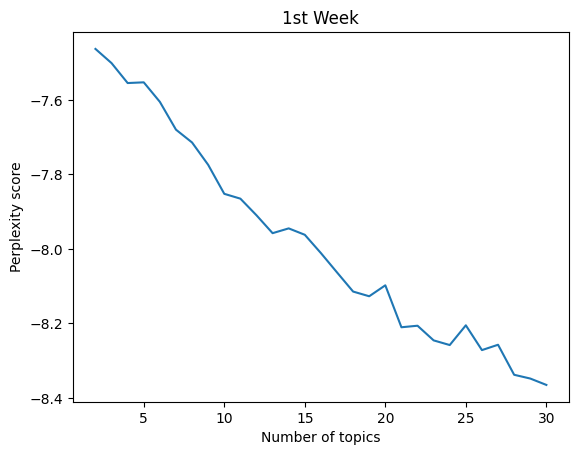

In [58]:
x = range(2, 31)
plt.plot(x, perplexity_values_1)
plt.title('1st Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

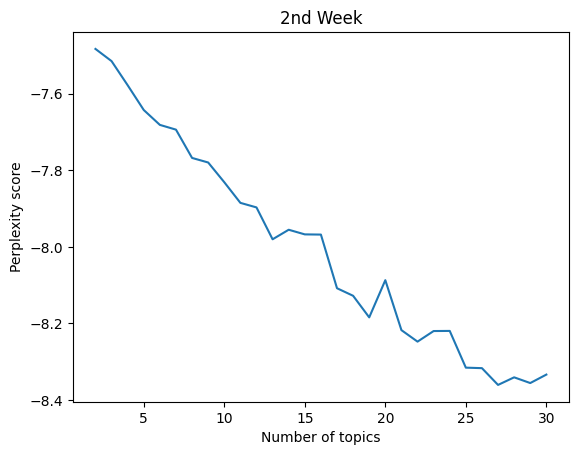

In [59]:
x = range(2, 31)
plt.plot(x, perplexity_values_2)
plt.title('2nd Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

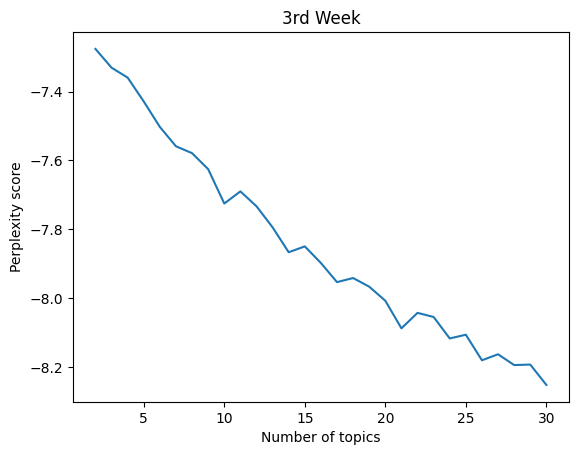

In [60]:
x = range(2, 31)
plt.plot(x, perplexity_values_3)
plt.title('3rd Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

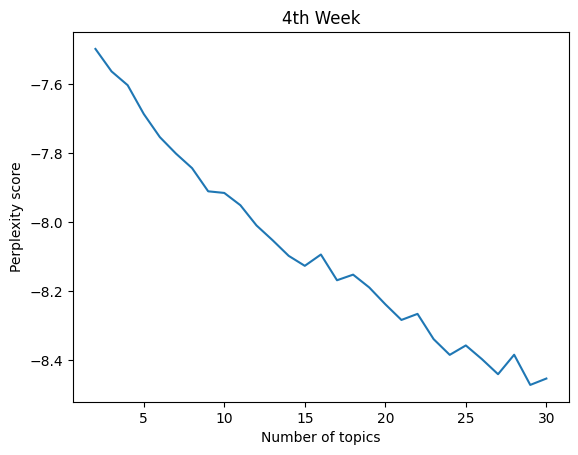

In [61]:
x = range(2, 31)
plt.plot(x, perplexity_values_4)
plt.title('4th Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

## B. Coherence - 높을수록 좋음

In [62]:
coherence_values_1 = []
coherence_values_2 = []
coherence_values_3 = []
coherence_values_4 = []

In [63]:
for i in range(2, 31):
    ldamodel_1 = gensim.models.ldamodel.LdaModel(corpus_1, num_topics=i, id2word=dictionary_1, random_state=42)
    coherence_model_lda_1 = CoherenceModel(model=ldamodel_1, texts=terms_1, dictionary=dictionary_1, topn=10)
    coherence_lda_1 = coherence_model_lda_1.get_coherence()
    coherence_values_1.append(coherence_lda_1)

In [64]:
for i in range(2, 31):
    ldamodel_2 = gensim.models.ldamodel.LdaModel(corpus_2, num_topics=i, id2word=dictionary_2, random_state=42)
    coherence_model_lda_2 = CoherenceModel(model=ldamodel_2, texts=terms_2, dictionary=dictionary_2, topn=10)
    coherence_lda_2 = coherence_model_lda_2.get_coherence()
    coherence_values_2.append(coherence_lda_2)

In [65]:
for i in range(2, 31):
    ldamodel_3 = gensim.models.ldamodel.LdaModel(corpus_3, num_topics=i, id2word=dictionary_3, random_state=42)
    coherence_model_lda_3 = CoherenceModel(model=ldamodel_3, texts=terms_3, dictionary=dictionary_3, topn=10)
    coherence_lda_3 = coherence_model_lda_3.get_coherence()
    coherence_values_3.append(coherence_lda_3)

In [66]:
for i in range(2, 31):
    ldamodel_4 = gensim.models.ldamodel.LdaModel(corpus_4, num_topics=i, id2word=dictionary_4, random_state=42)
    coherence_model_lda_4 = CoherenceModel(model=ldamodel_4, texts=terms_4, dictionary=dictionary_4, topn=10)
    coherence_lda_4 = coherence_model_lda_4.get_coherence()
    coherence_values_4.append(coherence_lda_4)

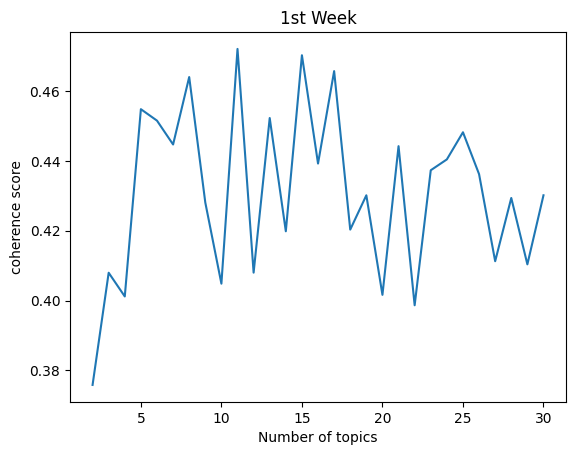

In [67]:
x = range(2, 31)
plt.plot(x, coherence_values_1)
plt.title('1st Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

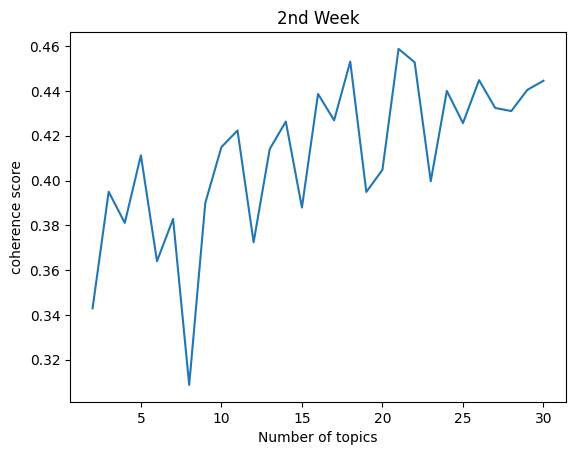

In [68]:
x = range(2, 31)
plt.plot(x, coherence_values_2)
plt.title('2nd Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

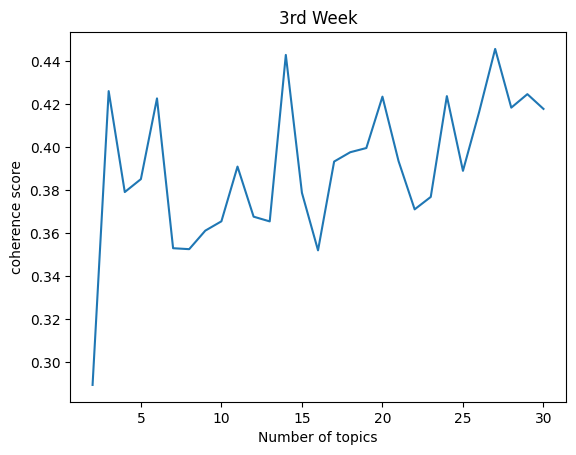

In [69]:
x = range(2, 31)
plt.plot(x, coherence_values_3)
plt.title('3rd Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

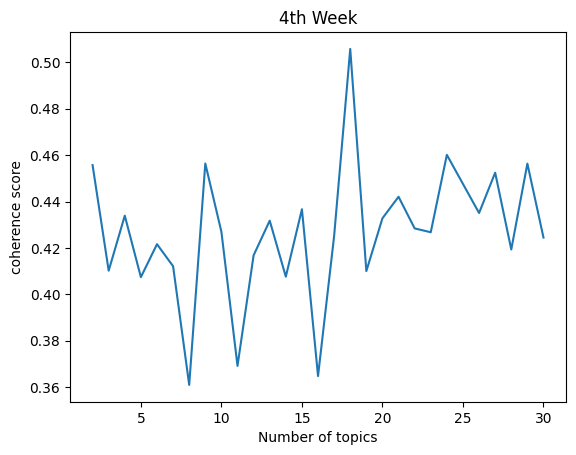

In [70]:
x = range(2, 31)
plt.plot(x, coherence_values_4)
plt.title('4th Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

최종적으로 Perplexity와 Coherence Score를 동시에 고려하여 최적의 주제 수를 선택

## I. 최종 LDA 분석

In [74]:
print(
    coherence_values_1.index(max(coherence_values_1)),
    coherence_values_2.index(max(coherence_values_2)),
    coherence_values_3.index(max(coherence_values_3)),
    coherence_values_4.index(max(coherence_values_4))
)

9 19 25 16


In [75]:
NUM_TOPICS_1 = coherence_values_1.index(max(coherence_values_1))
NUM_TOPICS_2 = coherence_values_2.index(max(coherence_values_2))
NUM_TOPICS_3 = coherence_values_3.index(max(coherence_values_3))
NUM_TOPICS_4 = coherence_values_4.index(max(coherence_values_4))

In [76]:
final_model_1 = gensim.models.LdaModel(
    corpus_1,
    num_topics=NUM_TOPICS_1, # 출력 토픽 수
    id2word=dictionary_1,
    random_state=42
)

In [77]:
final_model_2 = gensim.models.LdaModel(
    corpus_2,
    num_topics=NUM_TOPICS_2, # 출력 토픽 수
    id2word=dictionary_2,
    random_state=42
)

In [78]:
final_model_3 = gensim.models.LdaModel(
    corpus_3,
    num_topics=NUM_TOPICS_3, # 출력 토픽 수
    id2word=dictionary_3,
    random_state=42
)

In [79]:
final_model_4 = gensim.models.LdaModel(
    corpus_4,
    num_topics=NUM_TOPICS_4, # 출력 토픽 수
    id2word=dictionary_4,
    random_state=42
)

In [80]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력

print(final_model_1.show_topics(4, 10), '\n')
print(final_model_2.show_topics(4, 10), '\n')
print(final_model_3.show_topics(4, 10), '\n')
print(final_model_4.show_topics(4, 10))

[(2, '0.013*"윤" + 0.009*"민주" + 0.009*"대통령" + 0.008*"대응" + 0.008*"시바" + 0.007*"이스라엘" + 0.006*"일화" + 0.006*"음주운전" + 0.006*"협력" + 0.006*"입건"'), (7, '0.012*"이스라엘" + 0.008*"고려아연" + 0.008*"사주" + 0.007*"헤즈볼라" + 0.007*"윤" + 0.007*"한일" + 0.007*"과" + 0.007*"자" + 0.006*"뉴욕증시" + 0.006*"거짓말"'), (6, '0.009*"레바논" + 0.008*"이스라엘" + 0.007*"의회" + 0.007*"헤즈볼라" + 0.007*"미국" + 0.007*"판매" + 0.007*"사태" + 0.007*"감소" + 0.006*"검찰" + 0.006*"원주"'), (4, '0.025*"레바논" + 0.015*"도착" + 0.014*"국민" + 0.014*"체류" + 0.014*"수송기" + 0.013*"군" + 0.010*"서울" + 0.009*"휴학" + 0.009*"공항" + 0.009*"이스라엘"')] 

[(3, '0.015*"한강" + 0.010*"작가" + 0.008*"끝" + 0.008*"혐의" + 0.008*"최고" + 0.008*"초" + 0.008*"수상" + 0.008*"노벨문학상" + 0.005*"언급" + 0.004*"배"'), (6, '0.009*"당선" + 0.009*"이창용" + 0.008*"신원식" + 0.006*"금융" + 0.006*"의결" + 0.006*"부산" + 0.006*"국가" + 0.006*"도" + 0.006*"확보" + 0.006*"주장"'), (5, '0.009*"수준" + 0.009*"목별" + 0.009*"대통령" + 0.009*"지하" + 0.009*"은" + 0.009*"일본" + 0.009*"률" + 0.009*"셋" + 0.009*"최근" + 0.009*"전망"'), (14, '0.018*"한강" + 0.011*"노

In [81]:
TOP_N = 20

In [82]:
final_word_dict_1 = {}
for i in range(NUM_TOPICS_1):
  final_words_1 = final_model_1.show_topic(i, topn=TOP_N)
  final_word_dict_1['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_1]
  final_word_df_1 = pd.DataFrame(final_word_dict_1)

In [83]:
final_word_dict_2 = {}
for i in range(NUM_TOPICS_2):
  final_words_2 = final_model_2.show_topic(i, topn=TOP_N)
  final_word_dict_2['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_2]
  final_word_df_2 = pd.DataFrame(final_word_dict_2)

In [84]:
final_word_dict_3 = {}
for i in range(NUM_TOPICS_3):
  final_words_3 = final_model_3.show_topic(i, topn=TOP_N)
  final_word_dict_3['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_3]
  final_word_df_3 = pd.DataFrame(final_word_dict_3)

In [85]:
final_word_dict_4 = {}
for i in range(NUM_TOPICS_4):
  final_words_4 = final_model_4.show_topic(i, topn=TOP_N)
  final_word_dict_4['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_4]
  final_word_df_4 = pd.DataFrame(final_word_dict_4)

In [86]:
final_word_df_1

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,대통령,윤,윤,대통령,레바논,전자,레바논,이스라엘,필리핀
1,윤,대통령,민주,윤,도착,영업,이스라엘,고려아연,대통령
2,이스라엘,특검법,대통령,대통령실,국민,삼성,의회,사주,뉴욕증시
3,싱가포르,부결,대응,김건희,체류,익,헤즈볼라,헤즈볼라,쓰레기
4,필리핀,이란,시바,위,수송기,예고,미국,윤,부양
5,이란,전자,이스라엘,북한,군,활,판매,한일,일제
6,순방,레바논,일화,여사,서울,소비,사태,과,새
7,내일,이스라엘,음주운전,국회,휴학,성장,감소,자,총리
8,사업,공격,협력,국악,공항,부진,검찰,뉴욕증시,나스닥
9,보복,김건희,입건,풍선,이스라엘,투자,원주,거짓말,전략


In [87]:
final_word_df_2

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10,Topic #11,Topic #12,Topic #13,Topic #14,Topic #15,Topic #16,Topic #17,Topic #18,Topic #19
0,추가,한강,한강,한강,한강,수준,당선,무인기,한국,윤,분,개월,한국,평양,한강,균,공개매수,한강,뉴스
1,무인기,노벨문학상,한국,작가,노벨,목별,이창용,한국,평양,대통령,지위,율,합참,무인기,노벨문학상,명태,고려아연,대통령,국민
2,대통령,수상,한반도,끝,수상,대통령,신원식,대통령,무인기,경제,개월,기준금리,무인기,한국,주장,발부,영풍,노벨문학상,군수
3,명태,폭파,노벨,혐의,한국,지하,금융,확인,침투,영광,북한,당선,국민,공격,한국,지원,확보,한동훈,대통령
4,첫,도로,택시,최고,문학상,은,의결,북,북,율,공적,인하,한강,이스라엘,이유,김영선,한국,수상,윤
5,김건희,무인기,선,초,정부,일본,부산,윤,합참,군수,여사,개표,평양,침투,경질,명령,인상,첫,다우
6,공개,합참,북한,수상,작가,률,국가,평양,이재성,라오스,한동훈,장,노벨문학상,노벨상,상승,행,성공,시바,보수
7,시,한국,주가,노벨문학상,노벨문학상,셋,도,침투,확인,투표,아세안,유력,당선,먼저,국감,대통령,분,윤,유한
8,균,연결,하락,언급,무인기,최근,확보,아세안,헤더,활동,라인,교육감,부양,그린,유임,동행,이상,삼성,북한
9,뉴스,평양,합참,배,정상,전망,주장,한일,도발,부산,자유,북한,경제,급락,명중,안위,무인기,로,언론


In [88]:
final_word_df_3

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10,...,Topic #16,Topic #17,Topic #18,Topic #19,Topic #20,Topic #21,Topic #22,Topic #23,Topic #24,Topic #25
0,정보,한동훈,금융,북,대통령실,오자,한동훈,북한,인하,윤,...,경찰,단계,성장,김건희,북한,대통령,경제,여사,파병,윤
1,대통령,면담,이번,대통령실,대통령,김,대통령,대통령실,북한,인천,...,출석,대통령,윤,파병,러시아,사망,발표,한동훈,특별,문다혜
2,발언,윤,주요,장,대표,여사,대표,러시아,파병,한동훈,...,대통령실,금감원,대통령,여사,주가,군사,성적표,김,감찰관,국민
3,유럽,대통령,국내,군수,한동훈,뜻,대통령실,병력,휘발유,이재명,...,경찰서,인천,률,불기소,진료,심,한동훈,파병,합의,실적
4,발,대표,일정,규제,면담,국정원,윤,대통령,후,선고,...,문다혜,상대,불,회,대통령실,승리,여사,너,러시아,취소
5,지난해,시작,파병,영광,파병,의혹,경제,한동훈,국정원,김,...,서울,손흥민,목표,오른,고난,달라,김건희,합병,여야,서스펜디드
6,모두,북,당선,헌법,경찰,도이치,발표,안보,조치,사망,...,러시아,한국은행,연간,코스닥,한동훈,범죄,북한,로보틱스,발표,호재
7,내지,활동,위협,대한민국,입장,이동,인하,면담,파리,법,...,음주운전,및,한동훈,당선,시즌,대응,회의,비율,대통령,장모
8,한국,김여사,내달,민주당,러시아,용산,김여사,증거,연장,국민,...,국내,터트려,경제,동행,중증,연속,국정감사,일부,협력,미래
9,트럼프,국정원,보장,정치,동행,정말,용산,풍선,범죄,대통령,...,준,리그,심,도이치,신분증,징역,명령,납득,임명,로켓


In [89]:
final_word_df_4

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10,Topic #11,Topic #12,Topic #13,Topic #14,Topic #15,Topic #16
0,한국,북한,대통령,성장,윤,코스닥,이란,영업,북한,계약,국정원,한동훈,개혁,이스라엘,주간,이란
1,파병,주간,대통령실,한동훈,률,김수미,이스라엘,실적,발사,북한,지지율,법,구형,이란,전망,이스라엘
2,북한,대통령실,윤,경제,성장,오른,북,익,고려아연,파병,세,정,이란,대통령실,북한,북한
3,삼성,파병,파병,대통령,한국,관련,폭발,전자,위협,원전,북한,발사,추진,북한,경제지표,공격
4,우승,렌스,군사,대통령실,불안,휴학,성장,삼성,삼성,당국,하락,국민,위반,윤,휴학,파병
5,신세계,키,러북,반드시,수출,의대,발사,파병,언론,체코,증가,위,김혜경,국정원,변동성,사망
6,시리즈,젤,뉴욕증시,올해,대통령실,별세,공격,대통령실,화재,협력,대통령실,국회,검찰,공개,나토,서부
7,백화점,가능성,러시아,률,경제,개장,코스피,북,러시아,전차,안보,파병,의료,대통령,뉴욕증시,북
8,푸틴,검토,북한,공격,북,북한,전자,빅,파병,이행,귀,북한,재,확대,승인,대통령실
9,쿠르스크,국정원,상승,첫,회의,민주당,보복,증시,확보,안보,유상증자,반도체,이스라엘,전망,의대,국제


In [90]:
print(final_model_1.print_topics(num_words=5), '\n')
print(final_model_2.print_topics(num_words=5), '\n')
print(final_model_3.print_topics(num_words=5), '\n')
print(final_model_4.print_topics(num_words=5))

[(0, '0.021*"대통령" + 0.010*"윤" + 0.009*"이스라엘" + 0.009*"싱가포르" + 0.008*"필리핀"'), (1, '0.014*"윤" + 0.014*"대통령" + 0.009*"특검법" + 0.008*"부결" + 0.008*"이란"'), (2, '0.013*"윤" + 0.009*"민주" + 0.009*"대통령" + 0.008*"대응" + 0.008*"시바"'), (3, '0.016*"대통령" + 0.016*"윤" + 0.009*"대통령실" + 0.009*"김건희" + 0.009*"위"'), (4, '0.025*"레바논" + 0.015*"도착" + 0.014*"국민" + 0.014*"체류" + 0.014*"수송기"'), (5, '0.016*"전자" + 0.013*"영업" + 0.013*"삼성" + 0.012*"익" + 0.007*"예고"'), (6, '0.009*"레바논" + 0.008*"이스라엘" + 0.007*"의회" + 0.007*"헤즈볼라" + 0.007*"미국"'), (7, '0.012*"이스라엘" + 0.008*"고려아연" + 0.008*"사주" + 0.007*"헤즈볼라" + 0.007*"윤"'), (8, '0.014*"필리핀" + 0.010*"대통령" + 0.008*"뉴욕증시" + 0.008*"쓰레기" + 0.008*"부양"')] 

[(0, '0.012*"추가" + 0.012*"무인기" + 0.012*"대통령" + 0.009*"명태" + 0.009*"첫"'), (1, '0.027*"한강" + 0.022*"노벨문학상" + 0.020*"수상" + 0.016*"폭파" + 0.012*"도로"'), (2, '0.012*"한강" + 0.012*"한국" + 0.010*"한반도" + 0.010*"노벨" + 0.007*"택시"'), (3, '0.015*"한강" + 0.010*"작가" + 0.008*"끝" + 0.008*"혐의" + 0.008*"최고"'), (4, '0.024*"한강" + 0.015*"노벨" + 0.014*"수상" + 0

In [91]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(NUM_TOPICS_1):
    print(final_model_1.get_document_topics(corpus_1)[i])

[(0, 0.012348949), (1, 0.9011847), (2, 0.012352445), (3, 0.012350174), (4, 0.012357521), (5, 0.012349221), (6, 0.012357313), (7, 0.012352022), (8, 0.012347707)]
[(8, 0.92589915)]
[(0, 0.010102182), (1, 0.01010368), (2, 0.010103354), (3, 0.01010237), (4, 0.010101799), (5, 0.010104753), (6, 0.010101637), (7, 0.010101777), (8, 0.9191785)]
[(0, 0.013890701), (1, 0.013895494), (2, 0.013890953), (3, 0.01389176), (4, 0.013889891), (5, 0.013891693), (6, 0.88886255), (7, 0.013896707), (8, 0.013890202)]
[(0, 0.015876835), (1, 0.01587953), (2, 0.01587644), (3, 0.015875727), (4, 0.015887126), (5, 0.015876222), (6, 0.8729732), (7, 0.015880296), (8, 0.015874615)]
[(0, 0.0185296), (1, 0.018529918), (2, 0.01851999), (3, 0.018528383), (4, 0.018521411), (5, 0.8517773), (6, 0.01854615), (7, 0.018524127), (8, 0.018523112)]
[(0, 0.012349205), (1, 0.012350514), (2, 0.012357104), (3, 0.012347827), (4, 0.9011968), (5, 0.012347827), (6, 0.012349597), (7, 0.012351298), (8, 0.01234988)]
[(0, 0.011113643), (1, 0.

In [92]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(NUM_TOPICS_2):
    print(final_model_2.get_document_topics(corpus_2)[i])

[(9, 0.86465824)]
[(6, 0.9138706)]
[(1, 0.8815703)]
[(1, 0.3573261), (7, 0.5432515)]
[(11, 0.90525883)]
[(5, 0.8646529)]
[(11, 0.8947297)]
[(4, 0.31988877), (11, 0.6055434)]
[(16, 0.91387016)]
[(16, 0.35779828), (17, 0.54277694)]
[(4, 0.32016388), (11, 0.6052683)]
[(1, 0.39229086), (8, 0.5082876)]
[(16, 0.7240784), (18, 0.16407332)]
[(16, 0.8646589)]
[(2, 0.8646568)]
[(2, 0.8646568)]
[(0, 0.88157386)]
[(4, 0.88156545)]
[(15, 0.84210104)]


In [93]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(NUM_TOPICS_3):
    print(final_model_3.get_document_topics(corpus_3)[i])

[(10, 0.680808), (21, 0.2041846)]
[(5, 0.90399426)]
[(12, 0.3850879), (20, 0.52290875)]
[(20, 0.8079921)]
[(7, 0.8628514)]
[(0, 0.87999576)]
[(5, 0.5403333), (18, 0.34466422)]
[(5, 0.8399953)]
[(22, 0.80799115)]
[(18, 0.86284924)]
[(5, 0.8933297)]
[(8, 0.52199066), (16, 0.3757828)]
[(5, 0.5398644), (18, 0.34513304)]
[(5, 0.8399953)]
[(6, 0.90399814)]
[(5, 0.6156677), (13, 0.30069125)]
[(12, 0.8799953)]
[(12, 0.9039948)]
[(5, 0.90399754)]
[(22, 0.8399966)]
[(16, 0.87999505)]
[(12, 0.5538091), (18, 0.31475556)]
[(8, 0.29694897), (18, 0.5880453)]
[(8, 0.8933285)]
[(13, 0.91272306)]


In [94]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(NUM_TOPICS_4):
    print(final_model_4.get_document_topics(corpus_4)[i])

[(4, 0.86605847)]
[(0, 0.010417124), (1, 0.010417129), (2, 0.010417134), (3, 0.010417124), (4, 0.010417125), (5, 0.010417124), (6, 0.010417125), (7, 0.010417122), (8, 0.010417124), (9, 0.010417124), (10, 0.010417125), (11, 0.010417124), (12, 0.010417124), (13, 0.010417124), (14, 0.010417126), (15, 0.84374315)]
[(0, 0.010417391), (1, 0.010417391), (2, 0.010417391), (3, 0.010417391), (4, 0.010417391), (5, 0.010417391), (6, 0.010417394), (7, 0.010417391), (8, 0.010417391), (9, 0.84373915), (10, 0.010417391), (11, 0.010417391), (12, 0.010417392), (13, 0.010417391), (14, 0.010417391), (15, 0.010417402)]
[(0, 0.010417192), (1, 0.010417196), (2, 0.010417193), (3, 0.01041719), (4, 0.01041719), (5, 0.010417192), (6, 0.010417192), (7, 0.010417192), (8, 0.010417212), (9, 0.010417197), (10, 0.010417192), (11, 0.010417192), (12, 0.01041719), (13, 0.010417194), (14, 0.010417193), (15, 0.8437421)]
[(3, 0.34478056), (6, 0.53021055)]
[(12, 0.88281053)]
[(4, 0.88279957)]
[(12, 0.88281053)]
[(7, 0.882809

## G. 최종 pyLDAvis 시각화

In [95]:
pyLDAvis.enable_notebook()

In [96]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_1 = pyLDAvis.gensim_models.prepare(final_model_1, corpus_1, dictionary_1)

final_data_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.138651  0.140770       1        1  14.727157
1     -0.020589 -0.108162       2        1  14.236448
0      0.095489 -0.028589       3        1  13.787929
8      0.096978  0.067193       4        1  10.193169
5     -0.004197  0.000642       5        1   9.991826
3      0.081688  0.094158       6        1   9.915386
6     -0.109336 -0.049760       7        1   9.234851
7      0.012569 -0.047008       8        1   9.221345
2     -0.013952 -0.069244       9        1   8.691888, topic_info=      Term       Freq      Total Category  logprob  loglift
478     전자  20.000000  20.000000  Default  30.0000  30.0000
1713    영업  13.000000  13.000000  Default  29.0000  29.0000
1163    체류  13.000000  13.000000  Default  28.0000  28.0000
2      레바논  39.000000  39.000000  Default  27.0000  27.0000
1715     익  12.000000  12.000000  Default  26.0000  26.0000
...    ...        ...        ...      ...      ...      ...
693     부산   2.429167   9.423658   Topic9  -5.3337   1.0871
647    필리핀   3.093766  30.848268   Topic9  -5.0919   0.1431
642   싱가포르   2.540182  18.843814   Topic9  -5.2890   0.4388
136     개월   2.428568  16.897965   Topic9  -5.3340   0.5029
26      총리   2.428970  17.207897   Topic9  -5.3338   0.4849

[569 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1069      6  0.909976   가장
387       5  0.701455  가처분
1319      4  0.664090   가치
1674      9  0.650471    간
1627      7  0.671258   간격
...     ...       ...  ...
669       5  0.346282   흉기
669       8  0.692563   흉기
220       2  0.513706   흑자
220       3  0.256853   흑자
1687      5  0.687393   힌튼

[1122 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 9, 6, 4, 7, 8, 3])

In [97]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_2 = pyLDAvis.gensim_models.prepare(final_model_2, corpus_2, dictionary_2)

final_data_2

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.114264 -0.010952       1        1  9.119123
4      0.097979 -0.085707       2        1  8.251463
11    -0.125785  0.067083       3        1  6.947429
8      0.119175  0.149430       4        1  6.641315
12     0.071616 -0.041851       5        1  5.645687
17     0.070047 -0.105253       6        1  5.615123
5     -0.024646 -0.125144       7        1  5.413334
16     0.033626  0.078954       8        1  5.411309
9     -0.059617 -0.049968       9        1  5.355062
18    -0.081816  0.013461      10        1  5.334455
0     -0.049797  0.041325      11        1  4.772553
2      0.003967 -0.023451      12        1  4.641583
7      0.081309  0.063688      13        1  4.453810
13     0.066030  0.076513      14        1  4.395672
6     -0.079120  0.033316      15        1  4.013151
10    -0.060870 -0.022972      16        1  3.582853
14    -0.040765 -0.013760      17        1  3.550746
15    -0.118311  0.050918      18        1  3.514552
3     -0.017283 -0.095631      19        1  3.340780, topic_info=       Term       Freq      Total Category  logprob  loglift
1270     뉴스  11.000000  11.000000  Default  30.0000  30.0000
765      평양  33.000000  33.000000  Default  29.0000  29.0000
442      한강  62.000000  62.000000  Default  28.0000  28.0000
763      침투  25.000000  25.000000  Default  27.0000  27.0000
440   노벨문학상  35.000000  35.000000  Default  26.0000  26.0000
...     ...        ...        ...      ...      ...      ...
592      경사   0.810572   6.084592  Topic19  -5.4931   1.3832
982       술   0.810571   2.978109  Topic19  -5.4931   2.0977
322       후   0.810568   5.811184  Topic19  -5.4931   1.4292
625      설립   0.810564   3.223733  Topic19  -5.4931   2.0184
339      국민   0.810561  22.119266  Topic19  -5.4931   0.0925

[1209 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
58        6  0.338940    가격
58       10  0.677881    가격
839      15  0.688122  가계부채
1452      4  0.539211    가도
304       2  0.567061    가동
...     ...       ...   ...
179       3  0.102765     힘
179       4  0.205531     힘
179       5  0.205531     힘
179      10  0.205531     힘
179      14  0.102765     힘

[2448 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 12, 9, 13, 18, 6, 17, 10, 19, 1, 3, 8, 14, 7, 11, 15, 16, 4])

In [98]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_3 = pyLDAvis.gensim_models.prepare(final_model_3, corpus_3, dictionary_3)

final_data_3

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.053682  0.159198       1        1  6.857683
21    -0.092321  0.019756       2        1  4.952570
1     -0.062569 -0.003462       3        1  4.931966
11    -0.092491  0.003855       4        1  4.567768
12    -0.013660 -0.021903       5        1  4.547166
18     0.047583  0.107767       6        1  4.533697
6     -0.106483 -0.019448       7        1  4.502806
13     0.191286  0.086873       8        1  4.478383
7     -0.053376 -0.014107       9        1  4.259988
10    -0.053828  0.064573      10        1  4.246208
9     -0.019475  0.070094      11        1  4.147003
23    -0.033145 -0.088103      12        1  4.122538
22    -0.004651 -0.017044      13        1  4.109599
20    -0.024527 -0.145773      14        1  4.090437
16     0.069562 -0.042889      15        1  3.863745
14    -0.012331 -0.055598      16        1  3.852759
17    -0.081539 -0.014843      17        1  3.716242
8      0.007528 -0.032779      18        1  3.561099
0      0.152215 -0.084693      19        1  3.523941
4     -0.040674  0.064994      20        1  3.361202
19     0.061738 -0.029516      21        1  3.139448
15     0.028828 -0.010817      22        1  2.978292
24     0.014872  0.007928      23        1  2.633681
2      0.066199 -0.083100      24        1  2.553112
3      0.104943  0.079035      25        1  2.468666, topic_info=     Term       Freq      Total Category  logprob  loglift
565    경제  24.000000  24.000000  Default  30.0000  30.0000
276    삼성  10.000000  10.000000  Default  29.0000  29.0000
10     면담  22.000000  22.000000  Default  28.0000  28.0000
799    오자  12.000000  12.000000  Default  27.0000  27.0000
305    최고  10.000000  10.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
813   의약품   0.545619   4.297173  Topic25  -5.2942   1.6377
315    상승   0.545614   7.516836  Topic25  -5.2942   1.0785
538    한국   0.545613  16.843989  Topic25  -5.2942   0.2717
1263   적용   0.545612   2.134025  Topic25  -5.2942   2.3376
555    실적   0.545610   4.264134  Topic25  -5.2942   1.6454

[1373 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         2  0.327803  가능성
0        10  0.327803  가능성
0        24  0.327803  가능성
329      11  0.710352   가담
757       7  0.732081  가속도
...     ...       ...  ...
159       7  0.107331    힘
159       8  0.107331    힘
159      14  0.107331    힘
159      23  0.107331    힘
159      24  0.107331    힘

[2420 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 22, 2, 12, 13, 19, 7, 14, 8, 11, 10, 24, 23, 21, 17, 15, 18, 9, 1, 5, 20, 16, 25, 3, 4])

In [99]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_4 = pyLDAvis.gensim_models.prepare(final_model_4, corpus_4, dictionary_4)

final_data_4

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.176724  0.058439       1        1  8.621962
12    -0.021438  0.103294       2        1  7.509310
4      0.066144 -0.111420       3        1  7.374658
0     -0.014177 -0.030961       4        1  6.959499
7     -0.030226  0.125631       5        1  6.848596
15    -0.056153 -0.003167       6        1  6.725589
13     0.040454  0.054963       7        1  6.617094
3     -0.076509 -0.032496       8        1  6.516098
10     0.043320 -0.120992       9        1  6.205296
8      0.070619 -0.020829      10        1  5.831023
2      0.094431 -0.013557      11        1  5.674174
14     0.018813  0.086325      12        1  5.326670
9     -0.032675 -0.072011      13        1  5.312599
6     -0.087532 -0.010306      14        1  5.084068
11    -0.101558  0.028654      15        1  4.789414
5     -0.090237 -0.041567      16        1  4.603950, topic_info=     Term       Freq      Total Category  logprob  loglift
571  이스라엘  28.000000  28.000000  Default  30.0000  30.0000
822    주간  19.000000  19.000000  Default  29.0000  29.0000
570    이란  32.000000  32.000000  Default  28.0000  28.0000
60    대통령  28.000000  28.000000  Default  27.0000  27.0000
102   한동훈  16.000000  16.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
65     매출   1.301647   8.995900  Topic16  -5.3037   1.1451
17     북한   1.614927  56.605201  Topic16  -5.0880  -0.4786
95     대표   1.301759  10.735323  Topic16  -5.3036   0.9684
200     법   1.301680  10.887229  Topic16  -5.3037   0.9543
309   김정은   1.301622  10.663970  Topic16  -5.3037   0.9750

[1032 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1535      8  0.650817    가금
839       8  0.654683  가까스로
506       1  0.326149    가능
506       2  0.163075    가능
506       4  0.163075    가능
...     ...       ...   ...
1512     11  0.653149   휴학생
194       1  0.629041    흑자
493       5  0.605011     희
810      13  0.626554   희랍어
1063     12  0.646017     힘

[2201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 13, 5, 1, 8, 16, 14, 4, 11, 9, 3, 15, 10, 7, 12, 6])